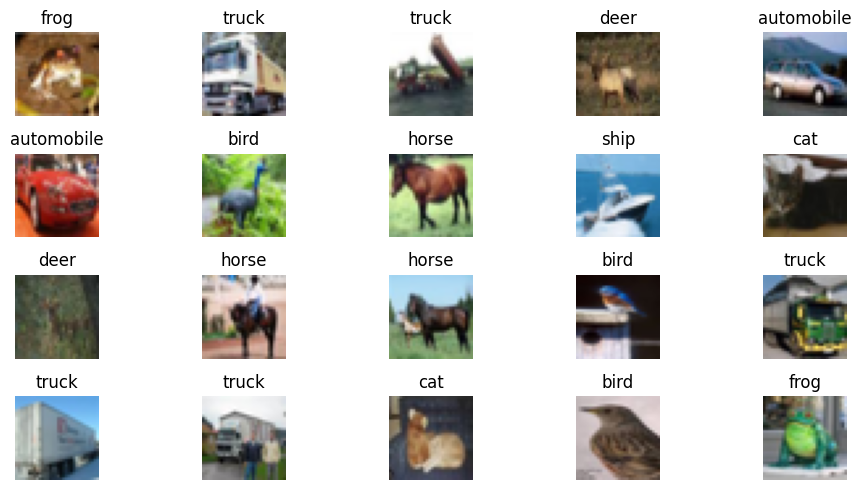

array([[[[0.23137255, 0.24313725, 0.24705882],
         [0.16862745, 0.18039216, 0.17647059],
         [0.19607843, 0.18823529, 0.16862745],
         ...,
         [0.61960784, 0.51764706, 0.42352941],
         [0.59607843, 0.49019608, 0.4       ],
         [0.58039216, 0.48627451, 0.40392157]],

        [[0.0627451 , 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509804, 0.21568627],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117647, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215686, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941176, 0.19607843],
         [0.47058824, 0.32941176, 0.19607843],
         [0.42745098, 0.28627451, 0.16470588]],

        ...,

        [[0.81568627, 0.66666667, 0.37647059],
         [0.78823529, 0.6       , 0.13333333]

In [1]:
import tensorflow as tf
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)


###load the dataset, plot some images samples and flatten+normalize data
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

sample_images = X_train[:20]


plt.figure(figsize=(10, 5))

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


for i in range(len(sample_images)):
    plt.subplot(4, 5, i + 1)
    plt.imshow(sample_images[i].astype('uint8'))
    plt.title(class_names[int(Y_train[i, 0])])  
    plt.axis('off')  

plt.tight_layout()
plt.show()

# Flatten the images
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)
X_train=X_train/255.0
X_test=X_test/255.0

X_train

In [2]:
###data standardization

from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

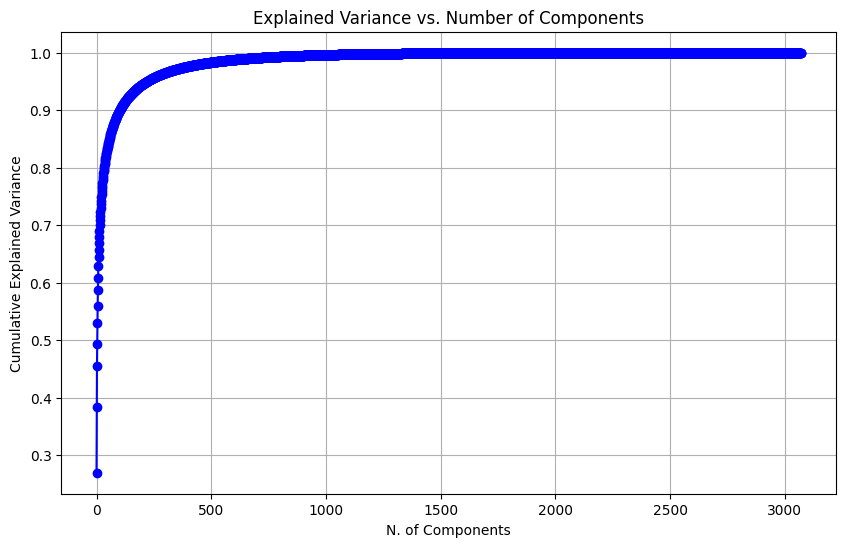

In [3]:
###PCA using inbuilt function to calculate explained variance and elbow rule to find the n. of principal components

pca = PCA()
pca.fit(X_train_scaled)
explained_variance_ratio = pca.explained_variance_ratio_


plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='-', color='b')
plt.xlabel('N. of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [4]:
### the number seems 450 so let's apply it to transform our sets 

num_components = 450  
pca = PCA(n_components=num_components)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [5]:
###resize the sets to save memory and computational resources

X_train_pca=X_train_pca[:5000,:]
Y_train = np.squeeze(Y_train[:5000])
print(Y_train)
print(X_train_pca.shape)
print(Y_train.shape)

[6 9 9 ... 5 4 6]
(5000, 450)
(5000,)


In [6]:
###first model: SVM using cross validation score

svc = svm.SVC()
cv_scores = cross_val_score(svc, X_train_pca, Y_train, cv=5)  

print("CV scores:", cv_scores)
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()
print(f"Mean : {mean_cv_score:.4f}")
print(f"Standard Deviation : {std_cv_score:.4f}")


svc.fit(X_train_pca, Y_train)
Y_pred_svm = svc.predict(X_test_pca)


svc_score = accuracy_score(Y_test, Y_pred_svm)
print(f"Accuracy Score on test: {svc_score:.4f}")

CV scores: [0.427 0.43  0.439 0.428 0.434]
Mean : 0.4316
Standard Deviation : 0.0044
Accuracy Score on test: 0.4455


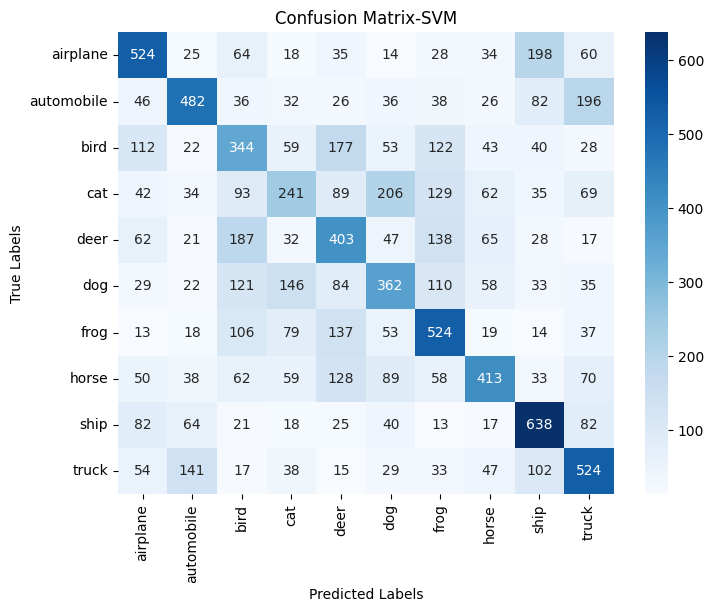

              precision    recall  f1-score   support

    airplane       0.52      0.52      0.52      1000
  automobile       0.56      0.48      0.52      1000
        bird       0.33      0.34      0.34      1000
         cat       0.33      0.24      0.28      1000
        deer       0.36      0.40      0.38      1000
         dog       0.39      0.36      0.38      1000
        frog       0.44      0.52      0.48      1000
       horse       0.53      0.41      0.46      1000
        ship       0.53      0.64      0.58      1000
       truck       0.47      0.52      0.49      1000

    accuracy                           0.45     10000
   macro avg       0.44      0.45      0.44     10000
weighted avg       0.44      0.45      0.44     10000



In [7]:
###plotting some useful metrics

cm = confusion_matrix(Y_test, Y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix-SVM')
plt.show()

report = classification_report(Y_test, Y_pred_svm, target_names=class_names)
print(report)

In [8]:
###2nd model:Random Forest classifier

randfor = RandomForestClassifier()
cv_scores = cross_val_score(randfor, X_train_pca, Y_train, cv=5)  
print("CV scores:", cv_scores)

mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()
print(f"Mean : {mean_cv_score:.4f}")
print(f"Standard Deviation: {std_cv_score:.4f}")


randfor.fit(X_train_pca, Y_train)
Y_pred_randfor = randfor.predict(X_test_pca)

random_forest_score = accuracy_score(Y_test, Y_pred_randfor)
print(f"Accuracy Score on test: {random_forest_score:.4f}")

CV scores: [0.324 0.318 0.327 0.309 0.282]
Mean : 0.3120
Standard Deviation: 0.0162
Accuracy Score on test: 0.3076


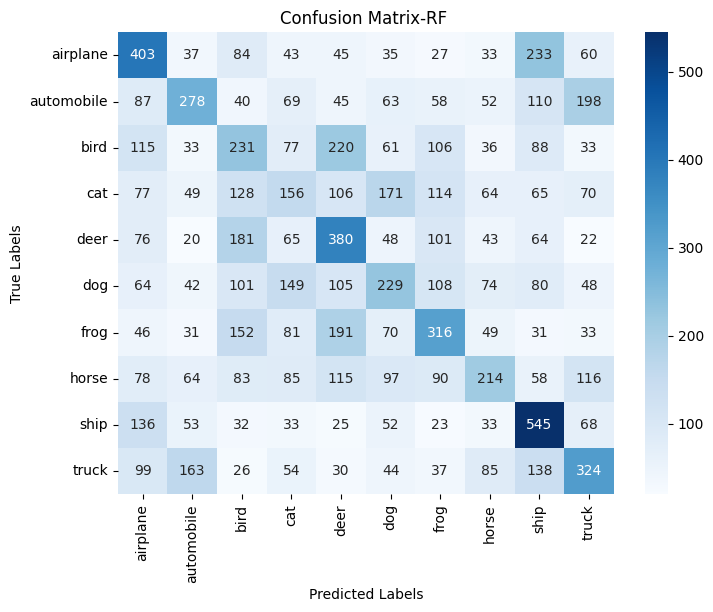

              precision    recall  f1-score   support

    airplane       0.34      0.40      0.37      1000
  automobile       0.36      0.28      0.31      1000
        bird       0.22      0.23      0.22      1000
         cat       0.19      0.16      0.17      1000
        deer       0.30      0.38      0.34      1000
         dog       0.26      0.23      0.24      1000
        frog       0.32      0.32      0.32      1000
       horse       0.31      0.21      0.25      1000
        ship       0.39      0.55      0.45      1000
       truck       0.33      0.32      0.33      1000

    accuracy                           0.31     10000
   macro avg       0.30      0.31      0.30     10000
weighted avg       0.30      0.31      0.30     10000



In [9]:
Y_pred_randfor = randfor.predict(X_test_pca)


cm = confusion_matrix(Y_test, Y_pred_randfor)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix-RF ')
plt.show()

report = classification_report(Y_test, Y_pred_randfor, target_names=class_names)
print(report)

In [10]:
###3rd model: logistic regression

logr = LogisticRegression(multi_class='ovr', solver='liblinear')


cv_scores = cross_val_score(logr, X_train_pca, Y_train, cv=5)  

mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()
print("CV scores:", cv_scores)
print(f"Mean : {mean_cv_score:.4f}")
print(f"Standard Deviation : {std_cv_score:.4f}")

logr.fit(X_train_pca, Y_train)


Y_pred_logr = logr.predict(X_test_pca)

logistic_regression_score = accuracy_score(Y_test, Y_pred_logr)
print(f"Accuracy Score on test: {logistic_regression_score:.4f}")

CV scores: [0.297 0.279 0.295 0.291 0.259]
Mean : 0.2842
Standard Deviation : 0.0141
Accuracy Score on test: 0.3174


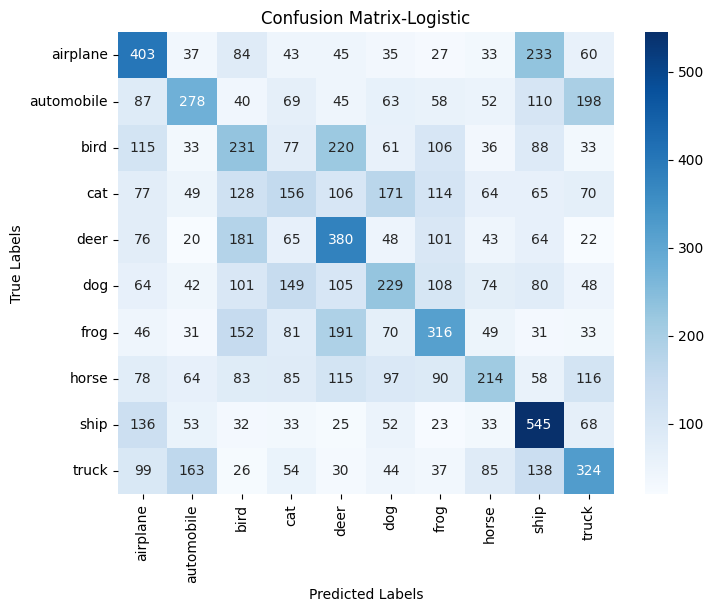

              precision    recall  f1-score   support

    airplane       0.37      0.36      0.36      1000
  automobile       0.38      0.35      0.36      1000
        bird       0.26      0.27      0.26      1000
         cat       0.22      0.19      0.20      1000
        deer       0.27      0.27      0.27      1000
         dog       0.25      0.24      0.24      1000
        frog       0.32      0.35      0.33      1000
       horse       0.37      0.34      0.35      1000
        ship       0.38      0.46      0.41      1000
       truck       0.35      0.35      0.35      1000

    accuracy                           0.32     10000
   macro avg       0.32      0.32      0.32     10000
weighted avg       0.32      0.32      0.32     10000



In [11]:
###metrics for logistic regression
cmlr = confusion_matrix(Y_test, Y_pred_logr)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix-Logistic')
plt.show()


report = classification_report(Y_test, Y_pred_logr, target_names=class_names)
print(report)